In [32]:
#Imports
import numpy as np
import pandas as pd
import torchvision
from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import json
import torch.nn as nn
import torch
import torch.optim as optim 
from tqdm import tqdm
from albumentations import Compose, Normalize,Resize
from albumentations.pytorch import ToTensorV2
import torch as th
import math
from torch.utils.data.sampler import WeightedRandomSampler
import os

In [33]:
#data_set path
fd_path = "/kaggle/input/pytorch-challange-flower-dataset/dataset"
train_path = "/kaggle/input/pytorch-challange-flower-dataset/dataset/train"
valid_path = "/kaggle/input/pytorch-challange-flower-dataset/dataset/valid"

In [34]:
data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()
                                     ])

In [35]:
train_data = datasets.ImageFolder(train_path, transform=data_transform)
valid_data = datasets.ImageFolder(valid_path, transform=data_transform)

In [36]:
print('train data size:', len(train_data))
print('valid data size:', len(valid_data))

train data size: 6552
valid data size: 818


In [37]:
train_data_loader = DataLoader(train_data, shuffle=True,batch_size=128, num_workers=2)
valid_data_loader = DataLoader(valid_data, shuffle=True,batch_size=128, num_workers=2)

In [38]:
# Get a batch of training data
inputs, classes = next(iter(train_data_loader))
print(inputs.shape)



torch.Size([128, 3, 224, 224])


65


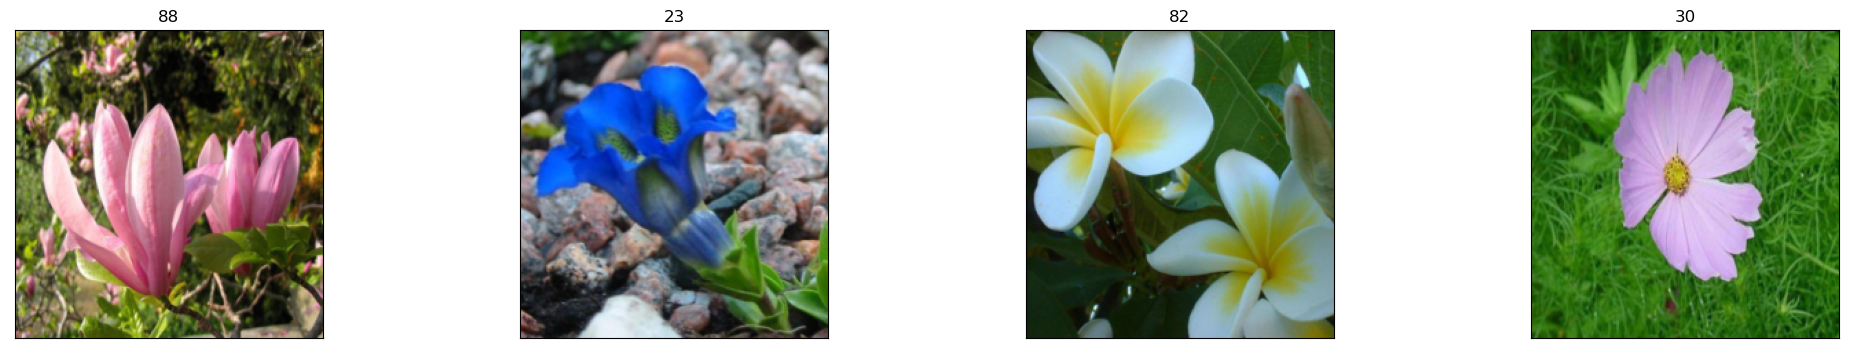

In [39]:
# Visualize some sample data
inputs, classes
inputs = inputs # convert images to numpy for display
print(len(np.unique(classes)))
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(inputs[idx], (1, 2, 0)))
    ax.set_title(classes[idx].numpy())


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu
print(device)

cuda


In [41]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)
model=model.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=50, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        loop = tqdm(enumerate(train_data_loader), total=len(train_data_loader)) # create a progress bar
        for batch_idx, (data, targets) in loop:
            optimizer.zero_grad()

            x    = data.to(device)
            y    = targets.to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]
            loop.set_description(f"Epoch {epoch}/{epochs} process: {int((batch_idx / len(train_data_loader)) * 100)}")
            loop.set_postfix(loss=loss.data.item())
        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)
            

        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [44]:
history = train(
    model = model,
    optimizer = optimizer,
    loss_fn = criterion,
    train_dl = train_data_loader,
    val_dl = valid_data_loader,
    device='cuda',
    epochs=15
)

train() called: model=ResNet, opt=Adam(lr=0.001000), epochs=15, device=cuda



Epoch 1/15 process: 98: 100%|██████████| 52/52 [00:57<00:00,  1.11s/it, loss=1.68]


Epoch   1/ 15, train loss:  2.91, train acc:  0.46, val loss:  1.51, val acc:  0.79


Epoch 2/15 process: 98: 100%|██████████| 52/52 [00:53<00:00,  1.04s/it, loss=1.01] 


Epoch   2/ 15, train loss:  1.02, train acc:  0.86, val loss:  0.79, val acc:  0.88


Epoch 3/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.04s/it, loss=0.786]


Epoch   3/ 15, train loss:  0.59, train acc:  0.92, val loss:  0.59, val acc:  0.90


Epoch 4/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.05s/it, loss=0.765]


Epoch   4/ 15, train loss:  0.40, train acc:  0.95, val loss:  0.51, val acc:  0.90


Epoch 5/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.05s/it, loss=0.396]


Epoch   5/ 15, train loss:  0.31, train acc:  0.96, val loss:  0.43, val acc:  0.91


Epoch 6/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.05s/it, loss=0.399]


Epoch   6/ 15, train loss:  0.25, train acc:  0.97, val loss:  0.40, val acc:  0.91


Epoch 7/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.05s/it, loss=0.356]


Epoch   7/ 15, train loss:  0.20, train acc:  0.98, val loss:  0.37, val acc:  0.92


Epoch 8/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.06s/it, loss=0.225]


Epoch   8/ 15, train loss:  0.17, train acc:  0.98, val loss:  0.35, val acc:  0.92


Epoch 9/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.06s/it, loss=0.105]


Epoch   9/ 15, train loss:  0.14, train acc:  0.99, val loss:  0.33, val acc:  0.93


Epoch 10/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.05s/it, loss=0.205] 


Epoch  10/ 15, train loss:  0.12, train acc:  0.99, val loss:  0.31, val acc:  0.93


Epoch 11/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.05s/it, loss=0.0663]


Epoch  11/ 15, train loss:  0.11, train acc:  0.99, val loss:  0.31, val acc:  0.93


Epoch 12/15 process: 98: 100%|██████████| 52/52 [00:54<00:00,  1.05s/it, loss=0.269] 


Epoch  12/ 15, train loss:  0.10, train acc:  0.99, val loss:  0.30, val acc:  0.93


Epoch 13/15 process: 98: 100%|██████████| 52/52 [00:53<00:00,  1.03s/it, loss=0.138] 


Epoch  13/ 15, train loss:  0.09, train acc:  0.99, val loss:  0.30, val acc:  0.93


Epoch 14/15 process: 98: 100%|██████████| 52/52 [00:53<00:00,  1.04s/it, loss=0.0801]


Epoch  14/ 15, train loss:  0.08, train acc:  1.00, val loss:  0.29, val acc:  0.93


Epoch 15/15 process: 98: 100%|██████████| 52/52 [00:53<00:00,  1.03s/it, loss=0.0526]


Epoch  15/ 15, train loss:  0.07, train acc:  1.00, val loss:  0.28, val acc:  0.93

Time total:     927.23 sec
Time per epoch: 61.82 sec


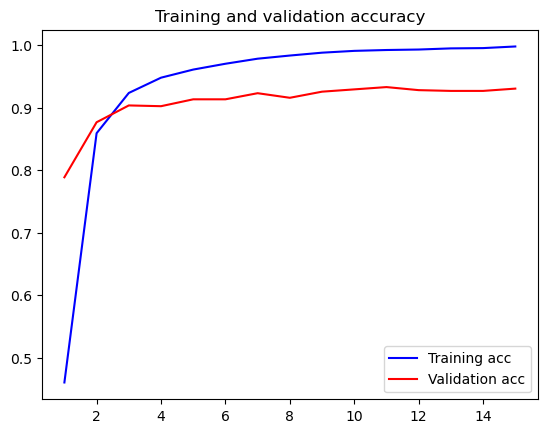

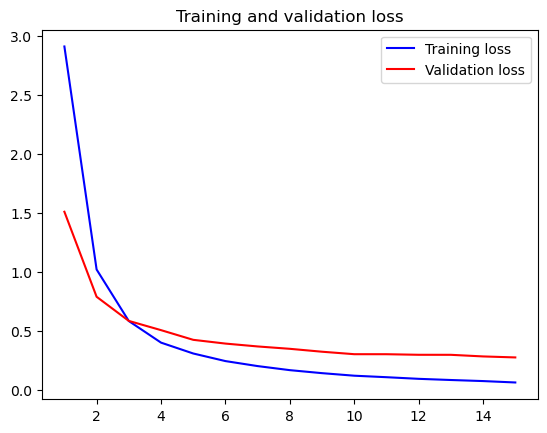

In [45]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [46]:
data_transforms_train = transforms.Compose([transforms.Resize((256,256)),
                                            transforms.RandomRotation(30),
                                            transforms.ColorJitter(),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(224), 
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_transforms_validation = transforms.Compose([transforms.Resize(256),
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [47]:
train_data = datasets.ImageFolder(train_path, transform=data_transforms_train)
valid_data = datasets.ImageFolder(valid_path, transform=data_transforms_validation)

206 27


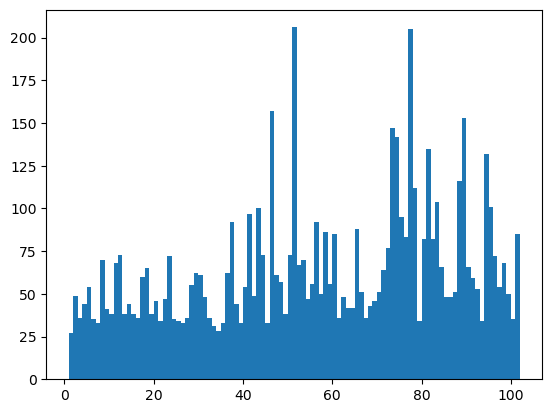

In [48]:
histogram=[]
for i in range(1,103):
    histogram.append(len(os.listdir(train_path+'/'+str(i))))
print(max(histogram),min(histogram))
plot=plt.hist(np.arange(1,103), np.arange(1,103), weights=histogram)

In [49]:
def make_weights_for_balanced_classes(images, nclasses):
    n_images = len(images)
    count_per_class=[]
    for i in range(1,103):
        count_per_class.append(len(os.listdir(train_path+'/'+str(i))))
    weight_per_class = [0.] * nclasses
    for i in range(nclasses):
        weight_per_class[i] = float(n_images) / float(count_per_class[i])
    weights = [0] * n_images
    for idx, (image, image_class) in enumerate(images):
        weights[idx] = weight_per_class[image_class]
    return weights

In [50]:
weights = make_weights_for_balanced_classes(train_data, 102)                                                                
weights = torch.DoubleTensor(weights)    
num_of_samples=len(weights)
print(num_of_samples)


6552


In [51]:

Train_sampler=WeightedRandomSampler(weights, num_of_samples,replacement=True)
valid_data_loader = DataLoader(valid_data, shuffle=True, batch_size=128, num_workers=2)
train_data_loader = DataLoader(train_data, batch_size=128, num_workers=2,sampler=Train_sampler)

In [53]:
loop = tqdm(enumerate(train_data_loader), total=len(train_data_loader)) # create a progress bar
for batch_idx, (data, targets) in loop:
    for target in targets:
        count_per_class[target] += 1

100%|██████████| 52/52 [00:51<00:00,  1.00it/s]


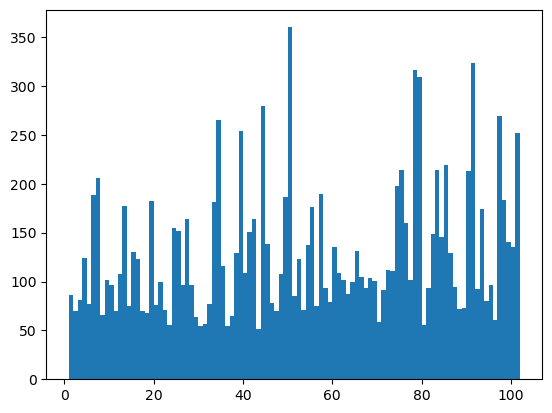

In [54]:
plot=plt.hist(np.arange(1,103), np.arange(1,103), weights=count_per_class)

In [55]:
# Get a batch of training data
inputs, classes = next(iter(train_data_loader))
print(inputs.shape)

torch.Size([128, 3, 224, 224])


In [57]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

cuda


In [58]:
model=model.to(device)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
history = train(
    model = model,
    optimizer = optimizer,
    loss_fn = criterion,
    train_dl = train_data_loader,
    val_dl = valid_data_loader,
    device='cuda',
    epochs=15
)

train() called: model=ResNet, opt=Adam(lr=0.001000), epochs=15, device=cuda



Epoch 1/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.14s/it, loss=1.74]


Epoch   1/ 15, train loss:  2.89, train acc:  0.48, val loss:  1.97, val acc:  0.61


Epoch 2/15 process: 98: 100%|██████████| 52/52 [01:00<00:00,  1.15s/it, loss=0.942]


Epoch   2/ 15, train loss:  1.18, train acc:  0.81, val loss:  1.15, val acc:  0.76


Epoch 3/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.15s/it, loss=0.655]


Epoch   3/ 15, train loss:  0.72, train acc:  0.89, val loss:  0.82, val acc:  0.83


Epoch 4/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.15s/it, loss=0.403]


Epoch   4/ 15, train loss:  0.54, train acc:  0.91, val loss:  0.66, val acc:  0.87


Epoch 5/15 process: 98: 100%|██████████| 52/52 [01:00<00:00,  1.16s/it, loss=0.424]


Epoch   5/ 15, train loss:  0.43, train acc:  0.93, val loss:  0.60, val acc:  0.87


Epoch 6/15 process: 98: 100%|██████████| 52/52 [01:00<00:00,  1.16s/it, loss=0.424]


Epoch   6/ 15, train loss:  0.35, train acc:  0.94, val loss:  0.52, val acc:  0.89


Epoch 7/15 process: 98: 100%|██████████| 52/52 [01:00<00:00,  1.16s/it, loss=0.285]


Epoch   7/ 15, train loss:  0.31, train acc:  0.95, val loss:  0.46, val acc:  0.90


Epoch 8/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.14s/it, loss=0.391]


Epoch   8/ 15, train loss:  0.28, train acc:  0.95, val loss:  0.47, val acc:  0.88


Epoch 9/15 process: 98: 100%|██████████| 52/52 [01:00<00:00,  1.16s/it, loss=0.271]


Epoch   9/ 15, train loss:  0.26, train acc:  0.95, val loss:  0.42, val acc:  0.90


Epoch 10/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.15s/it, loss=0.109]


Epoch  10/ 15, train loss:  0.22, train acc:  0.96, val loss:  0.43, val acc:  0.90


Epoch 11/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.15s/it, loss=0.163]


Epoch  11/ 15, train loss:  0.21, train acc:  0.96, val loss:  0.40, val acc:  0.90


Epoch 12/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.14s/it, loss=0.235]


Epoch  12/ 15, train loss:  0.19, train acc:  0.97, val loss:  0.37, val acc:  0.91


Epoch 13/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.14s/it, loss=0.114] 


Epoch  13/ 15, train loss:  0.17, train acc:  0.97, val loss:  0.37, val acc:  0.90


Epoch 14/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.15s/it, loss=0.373]


Epoch  14/ 15, train loss:  0.17, train acc:  0.97, val loss:  0.36, val acc:  0.92


Epoch 15/15 process: 98: 100%|██████████| 52/52 [00:59<00:00,  1.15s/it, loss=0.228] 


Epoch  15/ 15, train loss:  0.15, train acc:  0.98, val loss:  0.36, val acc:  0.91

Time total:     1014.82 sec
Time per epoch: 67.65 sec


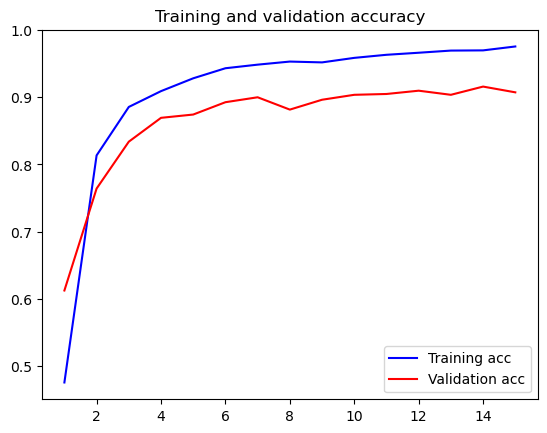

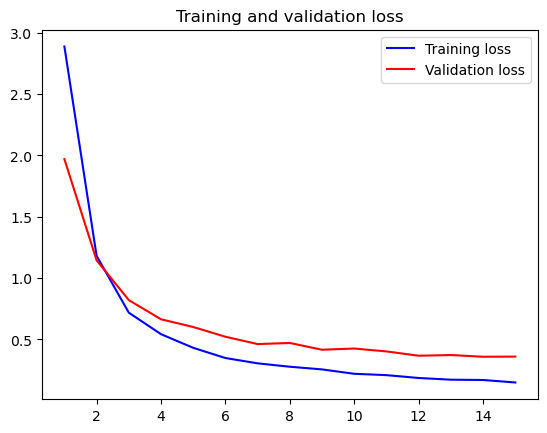

In [61]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [62]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)
model=model.to(device)

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [64]:
history = train(
    model = model,
    optimizer = optimizer,
    loss_fn = criterion,
    train_dl = train_data_loader,
    val_dl = valid_data_loader,
    device='cuda',
    epochs=15
)

train() called: model=ResNet, opt=Adam(lr=0.000100), epochs=15, device=cuda



Epoch 1/15 process: 98: 100%|██████████| 52/52 [01:09<00:00,  1.34s/it, loss=1.38]


Epoch   1/ 15, train loss:  2.60, train acc:  0.50, val loss:  1.64, val acc:  0.70


Epoch 2/15 process: 98: 100%|██████████| 52/52 [01:10<00:00,  1.36s/it, loss=0.749]


Epoch   2/ 15, train loss:  0.65, train acc:  0.90, val loss:  0.59, val acc:  0.91


Epoch 3/15 process: 98: 100%|██████████| 52/52 [01:11<00:00,  1.37s/it, loss=0.294] 


Epoch   3/ 15, train loss:  0.23, train acc:  0.97, val loss:  0.26, val acc:  0.95


Epoch 4/15 process: 98: 100%|██████████| 52/52 [01:11<00:00,  1.37s/it, loss=0.274] 


Epoch   4/ 15, train loss:  0.09, train acc:  0.99, val loss:  0.17, val acc:  0.97


Epoch 5/15 process: 98: 100%|██████████| 52/52 [01:10<00:00,  1.35s/it, loss=0.0918]


Epoch   5/ 15, train loss:  0.05, train acc:  0.99, val loss:  0.15, val acc:  0.97


Epoch 6/15 process: 98: 100%|██████████| 52/52 [01:11<00:00,  1.38s/it, loss=0.069] 


Epoch   6/ 15, train loss:  0.04, train acc:  1.00, val loss:  0.13, val acc:  0.98


Epoch 7/15 process: 98: 100%|██████████| 52/52 [01:09<00:00,  1.34s/it, loss=0.0707]


Epoch   7/ 15, train loss:  0.03, train acc:  1.00, val loss:  0.12, val acc:  0.97


Epoch 8/15 process: 98: 100%|██████████| 52/52 [01:10<00:00,  1.35s/it, loss=0.0288] 


Epoch   8/ 15, train loss:  0.02, train acc:  1.00, val loss:  0.12, val acc:  0.98


Epoch 9/15 process: 98: 100%|██████████| 52/52 [01:10<00:00,  1.36s/it, loss=0.0344] 


Epoch   9/ 15, train loss:  0.01, train acc:  1.00, val loss:  0.09, val acc:  0.99


Epoch 10/15 process: 98: 100%|██████████| 52/52 [01:10<00:00,  1.35s/it, loss=0.0713] 


Epoch  10/ 15, train loss:  0.02, train acc:  1.00, val loss:  0.14, val acc:  0.96


Epoch 11/15 process: 98: 100%|██████████| 52/52 [01:11<00:00,  1.37s/it, loss=0.0491] 


Epoch  11/ 15, train loss:  0.02, train acc:  1.00, val loss:  0.12, val acc:  0.97


Epoch 12/15 process: 98: 100%|██████████| 52/52 [01:10<00:00,  1.35s/it, loss=0.0229] 


Epoch  12/ 15, train loss:  0.02, train acc:  1.00, val loss:  0.10, val acc:  0.98


Epoch 13/15 process: 98: 100%|██████████| 52/52 [01:11<00:00,  1.37s/it, loss=0.0396] 


Epoch  13/ 15, train loss:  0.01, train acc:  1.00, val loss:  0.09, val acc:  0.98


Epoch 14/15 process: 98: 100%|██████████| 52/52 [01:09<00:00,  1.34s/it, loss=0.0691] 


Epoch  14/ 15, train loss:  0.01, train acc:  1.00, val loss:  0.10, val acc:  0.97


Epoch 15/15 process: 98: 100%|██████████| 52/52 [01:10<00:00,  1.36s/it, loss=0.0142] 


Epoch  15/ 15, train loss:  0.02, train acc:  1.00, val loss:  0.11, val acc:  0.97

Time total:     1178.15 sec
Time per epoch: 78.54 sec


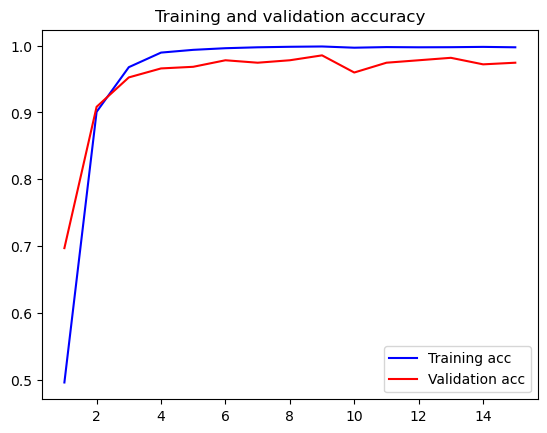

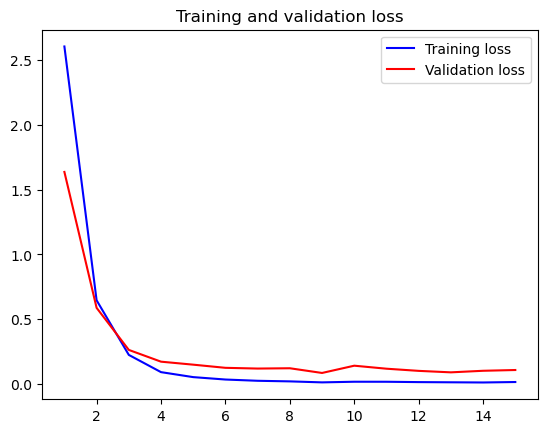

In [65]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()